
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BACS module
from bacs.agents.bacs import BACS, Configuration

# Load Metrics
from my_example.metrics.MazeMetrics import \
    _maze_metrics, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from my_example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "Littman57-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
DO_GA = True
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BACS Set Up
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ □ ■ ■ A ■ ■ □ □ □ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ $ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BACS - Exploration

In [4]:
%%time
#%%prun -l 0.5 -T profiling.txt

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 2min 32s, sys: 1.19 s, total: 2min 33s
Wall time: 2min 43s


### Performance

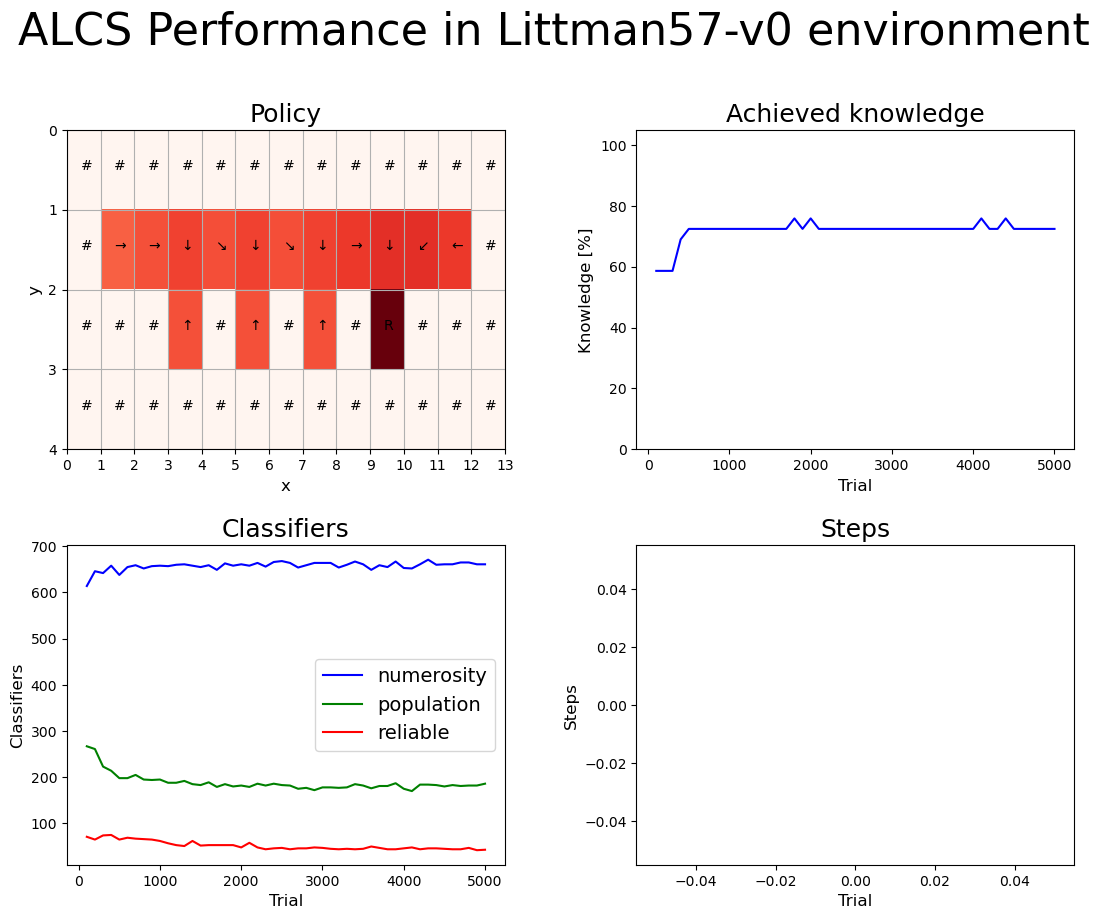

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
duplicate_population_explore = agent_explore.duplicate_population()
agent_explore.zip_population()
population_explore = agent_explore.get_population()

print(_maze_metrics(duplicate_population_explore, maze))
print(_maze_metrics(population_explore, maze))

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(duplicate_population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

pep_error = _enhanced_effect_error(duplicate_population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

{'knowledge': 72.41379310344827, 'population': 186, 'numerosity': 661, 'reliable': 43}
{'knowledge': 72.41379310344827, 'population': 151, 'numerosity': 612, 'reliable': 37}
Mean reliable population specifity is  (0.2616279069767442, 0.21052631578947367, 0.65)
Mean reliable population specifity is  (0.23986486486486486, 0.17578125, 0.65)
Accumulated Error on PEP Probabilities : 0.462962962962963 %
Accumulated Error on PEP Probabilities : 0.462962962962963 %


### Configuration of Exploitation

In [7]:
cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    epsilon=0.
)

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    epsilon=0.0
)

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
)

### Utilities

In [8]:
def print_avg_steps(metrics_exploit_no_rl, metrics_exploit_rl_start, metrics_exploit_rl, NUMBER_OF_EXPLOIT_TRIALS_NO_RL, NUMBER_OF_EXPLOIT_TRIALS_RL_START, NUMBER_OF_EXPLOIT_TRIALS_RL):

    avg_step_exploit_no_rl = 0
    for trial in metrics_exploit_no_rl:
        avg_step_exploit_no_rl += trial['steps_in_trial']
    avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
          " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

    avg_step_exploit_rl_start = 0
    for trial in metrics_exploit_rl_start:
        avg_step_exploit_rl_start += trial['steps_in_trial']
    avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
    print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
          " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

    avg_step_exploit_rl = 0
    for trial in metrics_exploit_rl:
        avg_step_exploit_rl += trial['steps_in_trial']
    avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
    print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
          " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

## Training of BACS - Uncompressed Population Exploitation

In [9]:
%%time

duplicate_agent_exploit_no_rl = BACS(cfg_exploit_no_rl, duplicate_population_explore)
duplicate_population_exploit_no_rl, duplicate_metrics_exploit_no_rl = duplicate_agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 4.56 s, sys: 12.5 ms, total: 4.57 s
Wall time: 4.59 s


In [10]:
%%time

duplicate_agent_exploit_rl_start = BACS(cfg_exploit_rl_start, duplicate_population_exploit_no_rl)
duplicate_population_exploit_rl_start, duplicate_metrics_exploit_rl_start = duplicate_agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 4.73 s, sys: 34.6 ms, total: 4.76 s
Wall time: 4.94 s


In [11]:
%%time

duplicate_agent_exploit_rl = BACS(cfg_exploit_rl, duplicate_population_exploit_rl_start)
duplicate_population_exploit_rl, duplicate_metrics_exploit_rl = duplicate_agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 5.38 s, sys: 75.7 ms, total: 5.46 s
Wall time: 5.72 s


## Training of BACS - Compressed Population Exploitation

In [12]:
%%time

agent_exploit_no_rl = BACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 4.94 s, sys: 86.2 ms, total: 5.02 s
Wall time: 5.74 s


In [13]:
%%time

agent_exploit_rl_start = BACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 4.94 s, sys: 85.1 ms, total: 5.03 s
Wall time: 5.98 s


In [14]:
%%time

agent_exploit_rl = BACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 4.58 s, sys: 68.1 ms, total: 4.65 s
Wall time: 5.45 s


#### Performance

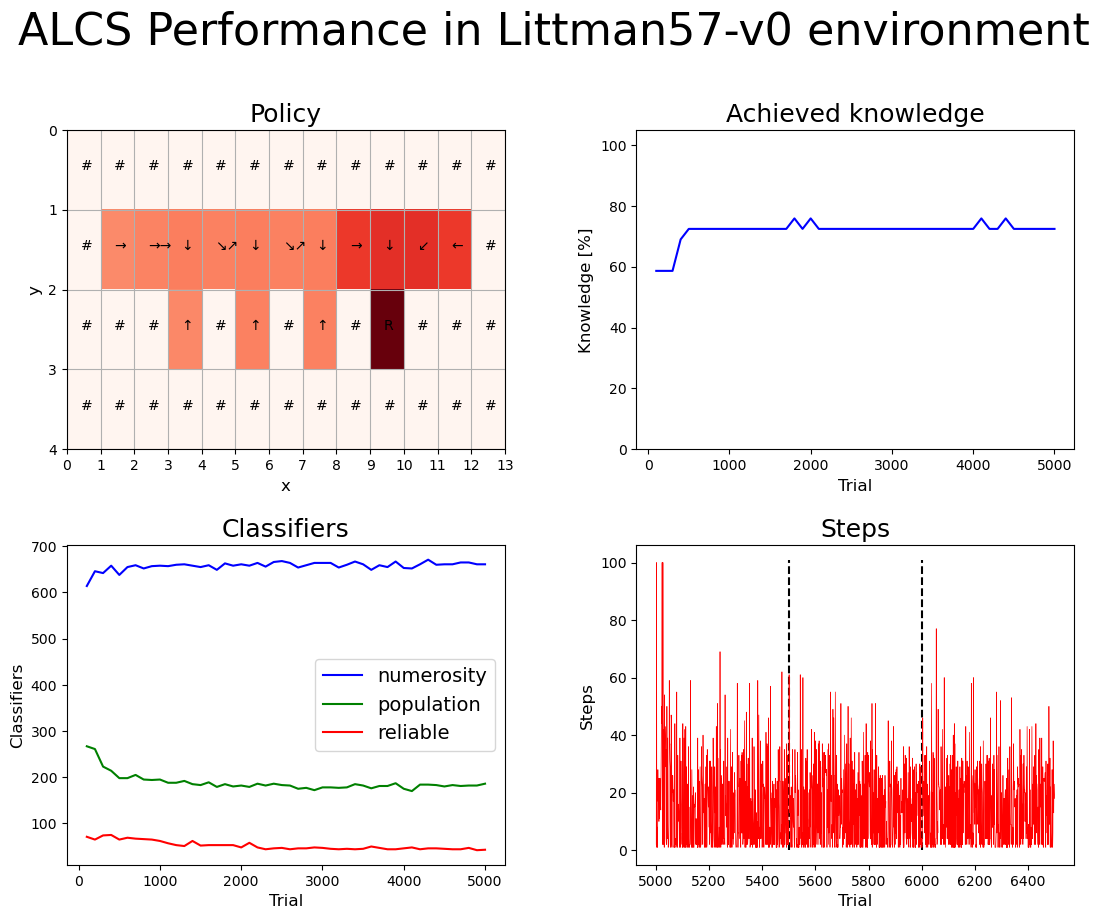

In [15]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

duplicate_metrics_exploit = duplicate_metrics_exploit_no_rl.copy()
for idx, item in enumerate(duplicate_metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    duplicate_metrics_exploit.append(tmp)
for idx, item in enumerate(duplicate_metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    duplicate_metrics_exploit.append(tmp)

duplicate_metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, duplicate_metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(duplicate_agent_exploit_rl, maze, duplicate_metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

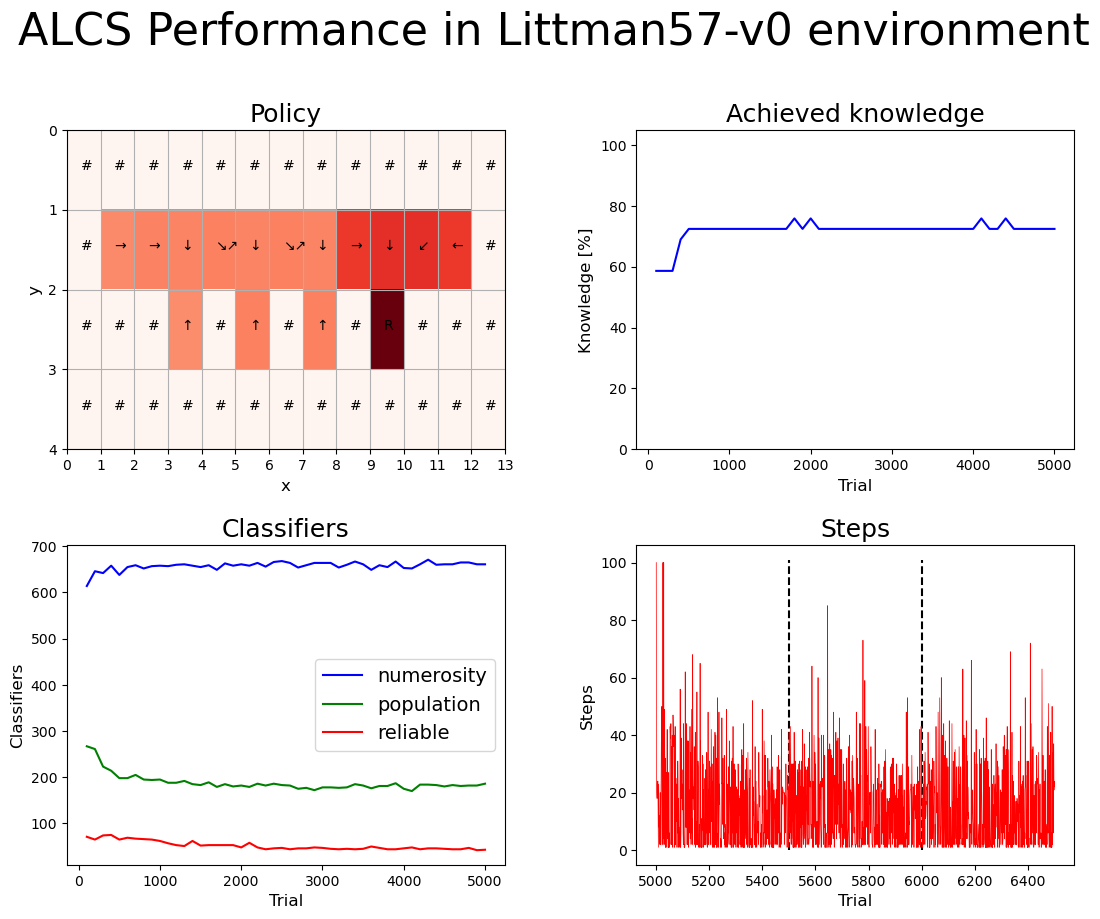

In [16]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [17]:
print_avg_steps(duplicate_metrics_exploit_no_rl, duplicate_metrics_exploit_rl_start, duplicate_metrics_exploit_rl,
                NUMBER_OF_EXPLOIT_TRIALS_NO_RL, NUMBER_OF_EXPLOIT_TRIALS_RL_START, NUMBER_OF_EXPLOIT_TRIALS_RL)

print(_maze_metrics(duplicate_population_explore, maze))
print(_maze_metrics(duplicate_population_exploit_no_rl, maze))
print(_maze_metrics(duplicate_population_exploit_rl_start, maze))
print(_maze_metrics(duplicate_population_exploit_rl, maze))

Average number of steps to solve the maze is  15.312  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  14.656  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  14.89  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 72.41379310344827, 'population': 186, 'numerosity': 661, 'reliable': 43}
{'knowledge': 72.41379310344827, 'population': 186, 'numerosity': 661, 'reliable': 43}
{'knowledge': 72.41379310344827, 'population': 186, 'numerosity': 661, 'reliable': 43}
{'knowledge': 72.41379310344827, 'population': 186, 'numerosity': 661, 'reliable': 43}


In [18]:
print_avg_steps(metrics_exploit_no_rl, metrics_exploit_rl_start, metrics_exploit_rl,
                NUMBER_OF_EXPLOIT_TRIALS_NO_RL, NUMBER_OF_EXPLOIT_TRIALS_RL_START, NUMBER_OF_EXPLOIT_TRIALS_RL)

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  15.512  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  14.836  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  14.042  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 72.41379310344827, 'population': 151, 'numerosity': 612, 'reliable': 37}
{'knowledge': 72.41379310344827, 'population': 151, 'numerosity': 612, 'reliable': 37}
{'knowledge': 72.41379310344827, 'population': 151, 'numerosity': 612, 'reliable': 37}
{'knowledge': 72.41379310344827, 'population': 151, 'numerosity': 612, 'reliable': 37}
